In [1]:
# часть 1. Импорт зависимостей

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Basics of Python data handling and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from shapely.geometry import Polygon

# Basics of GIS
import geopandas as gpd

# The core of this example
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

# Machine learning
import lightgbm as lgb
from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing

# Misc
import pickle
import sys
import os
import datetime
import itertools
from tqdm import tqdm_notebook as tqdm
import enum

# Basik math
from math import sqrt

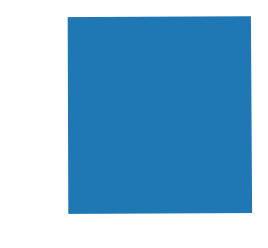

In [51]:
# часть 2. Импорт зависимостей
# .kmz files are unsupported

# Folder where data for running the notebook is stored
DATA_FOLDER = ('C:/Users/frolui/Documents/GitHub/using-eo-learn-in-remote-sensing-/diplom_project')

# Load geojson file
country = gpd.read_file(os.path.join(DATA_FOLDER, 'place.geojson'))

# # Загрузить файл с изучаемой территорией
# country = gpd.read_file('D:/YandexDisk/курсач_5/source/place.geojson') 

# Конвертирование CRS в UTM_35N
country_crs = CRS.UTM_35N
country = country.to_crs(crs={'init': CRS.ogc_string(country_crs)})

# Получение полигонального объекта с формой
country_shape = country.geometry.values.tolist()[-1]

# Plot country
country.plot()
plt.axis('off');

In [52]:
# 2.1

# Print size
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2] - country_shape.bounds[0],
                                                             country_shape.bounds[3] - country_shape.bounds[1]))

Dimension of the area is 14410 x 15443 m2


In [53]:
# 2.2

use_smaller_patches = True

# Create the splitter to obtain a list of bboxes
bbox_splitter_large = BBoxSplitter([country_shape], country_crs, (2, 2))
bbox_splitter_small = BBoxSplitter([country_shape], country_crs, (2 * 3, 2 * 3))

bbox_splitter = bbox_splitter_small if use_smaller_patches else bbox_splitter_large

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

In [54]:
# часть 3. Выбор центрального контейнера

ID = 15 if use_smaller_patches else 190

# Obtain surrounding patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)
        
# Check if final size is 3x3
if len(patchIDs) != 9:
    print('Warning! Use a different central patch ID, this one is on the border.')  

# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3, 3))).ravel()   

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]
df = pd.DataFrame({'index_x': idxs_x, 'index_y': idxs_y})

gdf = gpd.GeoDataFrame(df, crs={'init': CRS.ogc_string(country_crs)}, geometry=geometry)

In [55]:
#3.1

# save to shapefile
shapefile_name = './selected_3x3_bboxes_dist_small_2.shp' if use_smaller_patches \
    else './selected_3x3_bboxes_dist_large_2.shp'
gdf.to_file(shapefile_name)

In [56]:
#3.2

poly = gdf['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)

# содержиме датафрейма
gdf.head()

,index_x,index_y,geometry
0,1,4,"POLYGON ((518913.6757253294 5727228.931828612,..."
1,2,4,"POLYGON ((521315.3085657184 5727228.931828612,..."
2,3,4,"POLYGON ((523716.9414061075 5727228.931828612,..."
3,1,3,"POLYGON ((518913.6757253294 5724655.036680756,..."
4,2,3,"POLYGON ((521315.3085657184 5724655.036680756,..."


(515791.5530328235, 531642.3297793912, 5716161.1826928295, 5733148.890668681)

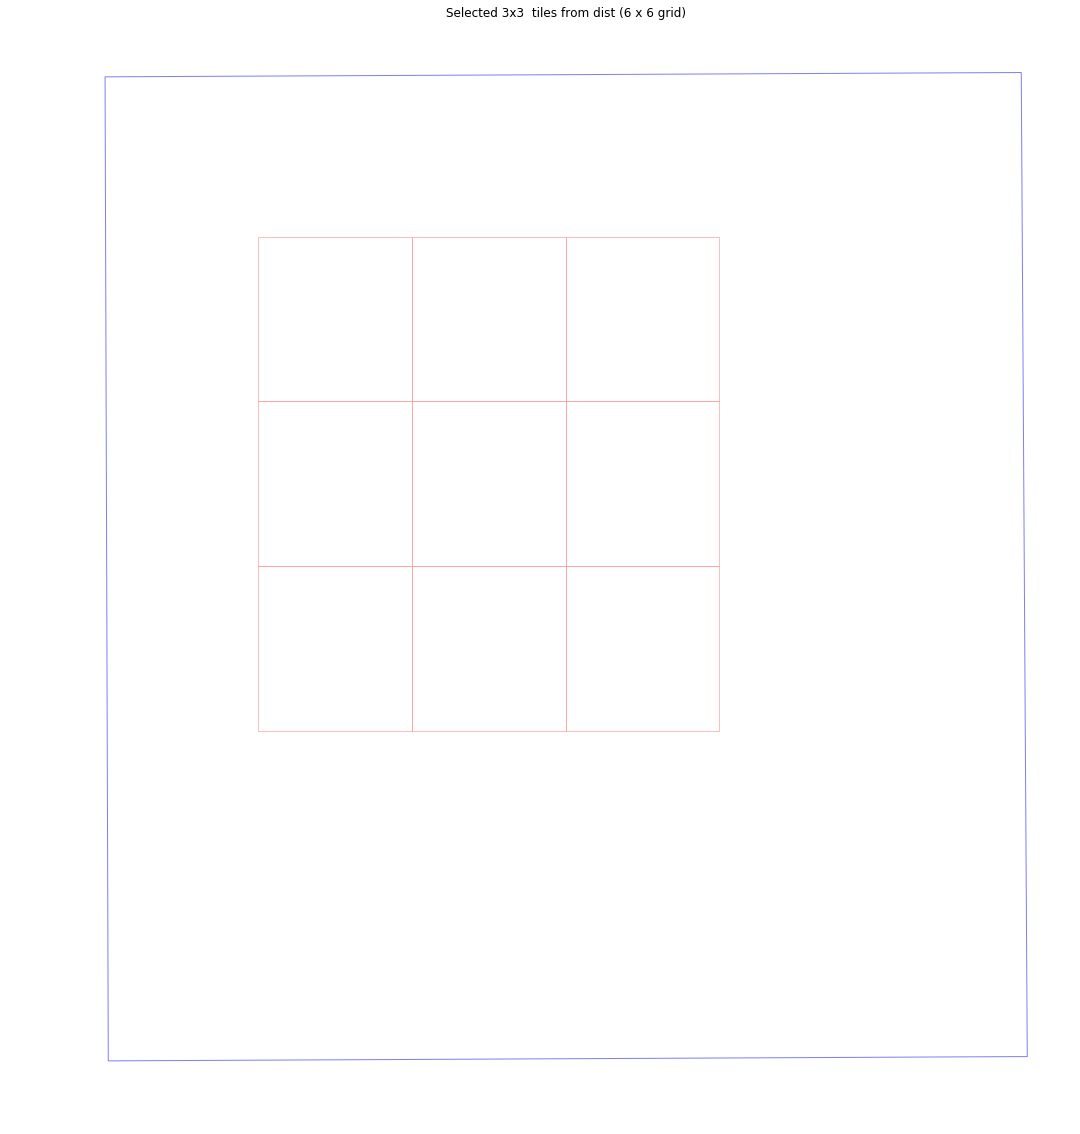

In [57]:
#3.3

fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu - xl) / 3, (yu - yl) / 5

# figure
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 3x3  tiles from dist (6 x 6 grid)');
plt.axis('off')

In [58]:
# часть 4. Описание задач рабочего процесса

class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool),
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

class CountValid(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))

        return eopatch

In [59]:
# rewrite this task for complite dNBR calculation

class DifferenceNormalBurningRatio(EOTask):
    """
    NBR = (9 - 12)/(9 + 12)
    DNBR = NBR_2 - NBR_1
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])

    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]

        dvi = (band_a - band_b)

        eopatch.add_feature(FeatureType.DATA, self.feature_name, dvi[..., np.newaxis])

        return eopatch

In [60]:
# Определение задач рабочего процесса
# TASK FOR BAND DATA

# add a request for R(B04), NIR (B08), Vegetation Red Edge VRE(B8A), Water vapour WV(B9), SWIR1(B11), SWIR2(B12)

# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover
# detection is performed in the next step
custom_script = 'return [B04, B08, B08A, B09, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C',
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

In [61]:
# Задача на расчет маски облачности
# cloud detection is performed at 80m resolution
# and the resulting cloud probability map and mask
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m',
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

In [62]:
# Задача на расчет показателей

# NBR = (9 - 12)/(9 + 12)
# DNBR = NBR_2 - NBR_1

dnbr = DifferenceNormalBurningRatio('DNBR', 'BANDS/3','BANDS/5')

In [63]:
# Задача на маску действительных пикселей
# validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(),
                                      'IS_VALID' # name of output mask
                                     )

# Задача на валидацию пикселей
# count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# Задача на сохранение вывода (опционально)
# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [64]:
# часть 5. Загрузка справочной карты

# Определение классов земного покрова справочной карты

class LULC(enum.Enum):
    NO_DATA            = (0,  'No Data',            'white')
    ROAD               = (1,  'Road',               'xkcd:lime')
    FOREST             = (2,  'Unclass_forest',     'xkcd:olive')
    SETTLEMENT         = (3,  'Settlement',         'orange')
    FIELDS             = (4,  'Fields',             'xkcd:tan')
    WATER              = (5,  'Water',              'xkcd:azure')    
    FOREST_DUB         = (6,  'Dub',                'xkcd:darkgreen')
    FOREST_GRAB        = (7,  'Grab',               'xkcd:green')
    FOREST_SOSNA       = (8,  'Sosna',              'xkcd:khaki')
    FOREST_MELKOL      = (9,  'Melkolistv',         'xkcd:navy')
    FOREST_BEREZA      = (10, 'Bereza',             'xkcd:plum')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

# example usecase
# LULC.BARELAND.id   # return 9

# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), lulc_cmap.N)


name_str = 'small' if use_smaller_patches else 'large'
land_cover_path = os.path.join(DATA_FOLDER, 'exemple_map.shp')

land_cover_data = gpd.read_file(land_cover_path)

rasterization_task = VectorToRaster(land_cover_data, (FeatureType.MASK_TIMELESS, 'LULC'),
                                    values_column='lulcid', raster_shape=(FeatureType.MASK, 'IS_VALID'),
                                    raster_dtype=np.uint8)

In [65]:
# часть 6. Формирование рабочего процесса

# Определение рабочего процесса - EOWorkflow из EOTask 
workflow = LinearWorkflow(
    add_data,
    add_clm,
    dnbr,
    add_sh_valmask,
    count_val_sh,
    save
)

In [66]:
%%time

# Execute the workflow
time_interval = ['2019-04-15', '2019-4-30'] # time interval for the SH request

# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    })

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=False)

executor.make_report()

Wall time: 1.28 s


In [67]:
EOPatch.load('./eopatches_small/eopatch_0/')

ValueError: Specified path ./eopatches_small/eopatch_0/ does not exist